In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn import utils

import datetime

import torch
torch.manual_seed(3)
np.random.seed(7)

import torch.nn as nn
from torch.autograd import Variable 
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.optim as optim

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
prof_df = pd.read_csv("D:/jupyter/data_2.csv", encoding='cp949')
prof_df

,point1,point2,point3,point4,point5,point6,point7,point8,point9,point10,...,point35,point36,point37,point38,point39,point40,point41,point42,point43,min
0,0.3980,0.325,0.3820,0.383,0.3020,0.267,0.343,0.415,0.445,0.409,...,0.274,0.179,0.0934,0.137,0.127,0.135,0.190,0.261,0.262,0.323
1,0.3980,0.325,0.3820,0.383,0.3020,0.267,0.343,0.415,0.445,0.409,...,0.274,0.179,0.0934,0.137,0.127,0.135,0.190,0.261,0.262,0.338
2,0.4110,0.448,0.4670,0.514,0.4670,0.477,0.505,0.558,0.567,0.620,...,0.514,0.486,0.4480,0.441,0.411,0.506,0.583,0.647,0.634,0.316
3,0.6390,0.725,0.6290,0.696,0.6320,0.693,0.594,0.651,0.635,0.720,...,0.576,0.526,0.5210,0.462,0.511,0.411,0.382,0.347,0.269,0.303
4,0.6740,0.641,0.5670,0.473,0.5530,0.500,0.564,0.607,0.583,0.534,...,0.667,0.665,0.6430,0.718,0.809,0.871,0.851,0.848,0.802,0.298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.5050,0.575,0.5320,0.450,0.3700,0.379,0.308,0.374,0.352,0.358,...,0.958,0.882,0.8280,0.784,0.714,0.810,0.865,0.772,0.706,0.307
373,0.3740,0.289,0.1900,0.183,0.0859,0.147,0.154,0.243,0.246,0.243,...,0.165,0.206,0.2130,0.261,0.343,0.348,0.433,0.451,0.447,0.341
374,0.3340,0.275,0.2820,0.273,0.2750,0.287,0.262,0.351,0.298,0.278,...,0.439,0.471,0.3940,0.307,0.277,0.303,0.346,0.353,0.453,0.332
375,0.0811,0.167,0.0957,0.291,0.3820,0.328,0.426,0.376,0.456,0.479,...,0.447,0.529,0.6120,0.549,0.639,0.554,0.567,0.537,0.498,0.332


In [3]:
data_frames = pd.DataFrame(prof_df)
x = data_frames.iloc[:,:-1]
y = data_frames.iloc[:,43:44]

mm = MinMaxScaler()
ss = StandardScaler()

X_np = mm.fit_transform(x)
y_np = mm.fit_transform(y)

X_train = X_np[:270, :]
X_test = X_np[270:, :]
y_train = y_np[:270]
y_test = y_np[270:] 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 
                                      
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([270, 1, 43]) torch.Size([270, 1])
Testing Shape torch.Size([107, 1, 43]) torch.Size([107, 1])


In [4]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.num_classes = 1  # number of output class 
        self.num_layers = 1  # number of layers
        self.input_size = 43  # number of input class 
        self.hidden_size = 2  # hidden state
        self.seq_length = 10  # sequence length

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(self.hidden_size, 30)  # fully connected 1
        self.fc_2 = nn.Linear(30, 15)  # fully connected last layer
        self.fc_3 = nn.Linear(15, self.num_classes)  # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))# internal state
        # Propagate input through LSTM

        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        out = self.fc_2(out)  
        out = self.relu(out)  # relu
        out = self.fc_3(out)  

        return out

In [5]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.detach().numpy())
    perc_y_true = np.exp(y_true.detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100   

In [15]:
num_epochs = 100  ###테스트
learning_rate = 0.00001 #0.001 lr
lstm = LSTM()
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, weight_decay=0.001)  # adam optimizer
train_loss = 0
train_acc = 0
lstm.train()
lstm.zero_grad()

train_loss_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i in range(len(X_train_tensors_final)):
        lstm.zero_grad()
        optimizer.zero_grad() 
        #lstm.hidden = [hidden for hidden in lstm.init_hidden()]
        
        outputs = lstm(X_train_tensors_final)  # forward pass
   
        # obtain the loss function
        loss = loss_function(outputs, y_train_tensors.view(-1,1))
        loss.backward()  # calculates the loss of the loss function
        optimizer.step()  # improve from loss, i.e backprop
        
        train_loss += loss.item()
        train_acc += metric(outputs, y_train_tensors)[0]
    
    train_loss = train_loss / X_train_tensors_final.shape[0]
    train_loss_list.append(train_loss)
    train_acc = train_acc / X_train_tensors_final.shape[0]
    train_acc_list.append(train_acc)
    
    if epoch % 1 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, train_loss))

Epoch: 0, loss: 0.29377
Epoch: 1, loss: 0.29046
Epoch: 2, loss: 0.28614
Epoch: 3, loss: 0.28191
Epoch: 4, loss: 0.27776
Epoch: 5, loss: 0.27369
Epoch: 6, loss: 0.26970
Epoch: 7, loss: 0.26580
Epoch: 8, loss: 0.26197
Epoch: 9, loss: 0.25822
Epoch: 10, loss: 0.25454
Epoch: 11, loss: 0.25095
Epoch: 12, loss: 0.24744
Epoch: 13, loss: 0.24403
Epoch: 14, loss: 0.24074
Epoch: 15, loss: 0.23755
Epoch: 16, loss: 0.23445
Epoch: 17, loss: 0.23144
Epoch: 18, loss: 0.22850
Epoch: 19, loss: 0.22563
Epoch: 20, loss: 0.22282
Epoch: 21, loss: 0.22007
Epoch: 22, loss: 0.21737
Epoch: 23, loss: 0.21472
Epoch: 24, loss: 0.21213
Epoch: 25, loss: 0.20958
Epoch: 26, loss: 0.20707
Epoch: 27, loss: 0.20461
Epoch: 28, loss: 0.20220
Epoch: 29, loss: 0.19984
Epoch: 30, loss: 0.19751
Epoch: 31, loss: 0.19523
Epoch: 32, loss: 0.19299
Epoch: 33, loss: 0.19079
Epoch: 34, loss: 0.18863
Epoch: 35, loss: 0.18650
Epoch: 36, loss: 0.18443
Epoch: 37, loss: 0.18239
Epoch: 38, loss: 0.18038
Epoch: 39, loss: 0.17842
Epoch: 40,

In [16]:
num_epochs = 100 ###테스트
learning_rate = 0.0001 #0.001 lr
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, weight_decay=0.001)  # adam optimizer
test_loss = 0
test_acc = 0
lstm.eval()

test_loss_list, test_acc_list = [], []
for epoch in range(num_epochs):
    for i in range(len(X_test_tensors_final)):  
        outputs = lstm(X_test_tensors_final)  # forward pass
   
        # obtain the loss function
        loss = loss_function(outputs, y_test_tensors.view(-1,1))
        loss.backward()  # calculates the loss of the loss function
        optimizer.step()  # improve from loss, i.e backprop
        
        test_loss += loss.item()
        test_acc += metric(outputs, y_test_tensors)[0]
    
    test_loss = test_loss / X_test_tensors_final.shape[0]
    test_loss_list.append(test_loss)
    test_acc = test_acc / X_test_tensors_final.shape[0]
    test_acc_list.append(test_acc)
    
    if epoch % 1 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, test_loss))

Epoch: 0, loss: 0.09562
Epoch: 1, loss: 0.10724
Epoch: 2, loss: 0.09716
Epoch: 3, loss: 0.09224
Epoch: 4, loss: 0.10331
Epoch: 5, loss: 0.08812
Epoch: 6, loss: 0.09374
Epoch: 7, loss: 0.08325
Epoch: 8, loss: 0.08923
Epoch: 9, loss: 0.08431
Epoch: 10, loss: 0.08793
Epoch: 11, loss: 0.08586
Epoch: 12, loss: 0.08634
Epoch: 13, loss: 0.08726
Epoch: 14, loss: 0.08495
Epoch: 15, loss: 0.08882
Epoch: 16, loss: 0.08346
Epoch: 17, loss: 0.09003
Epoch: 18, loss: 0.08229
Epoch: 19, loss: 0.09131
Epoch: 20, loss: 0.08121
Epoch: 21, loss: 0.09206
Epoch: 22, loss: 0.08049
Epoch: 23, loss: 0.09281
Epoch: 24, loss: 0.08003
Epoch: 25, loss: 0.09292
Epoch: 26, loss: 0.07993
Epoch: 27, loss: 0.09299
Epoch: 28, loss: 0.08016
Epoch: 29, loss: 0.09247
Epoch: 30, loss: 0.08067
Epoch: 31, loss: 0.09192
Epoch: 32, loss: 0.08154
Epoch: 33, loss: 0.09082
Epoch: 34, loss: 0.08255
Epoch: 35, loss: 0.08979
Epoch: 36, loss: 0.08391
Epoch: 37, loss: 0.08830
Epoch: 38, loss: 0.08522
Epoch: 39, loss: 0.08691
Epoch: 40,

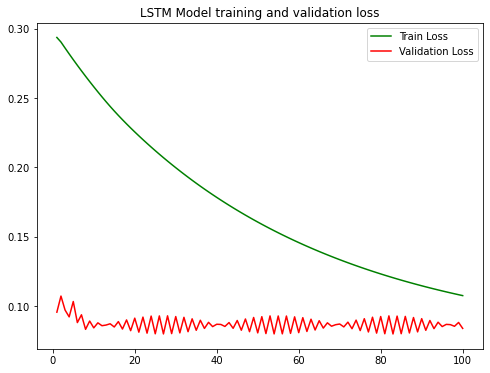

In [17]:
value, idx= np.array(train_loss_list).min(), np.array(train_loss_list).argmin()
plt.figure(figsize= (8, 6))
plt.title('LSTM Model training and validation loss')
plt.plot(np.arange(1, 101), train_loss_list, 'g', label= 'Train Loss')
plt.plot(np.arange(1, 101), test_loss_list, 'r', label= 'Validation Loss')
plt.legend(loc= 'upper right')

In [ ]:
plt.figure(figsize= (8, 6))
plt.plot(np.arange(1, 21), train_loss_list, 'g', label= 'Train Loss')
plt.plot(np.arange(1, 21), test_loss_list, 'r', label= 'Test Loss')
plt.legend(loc= 'upper right')

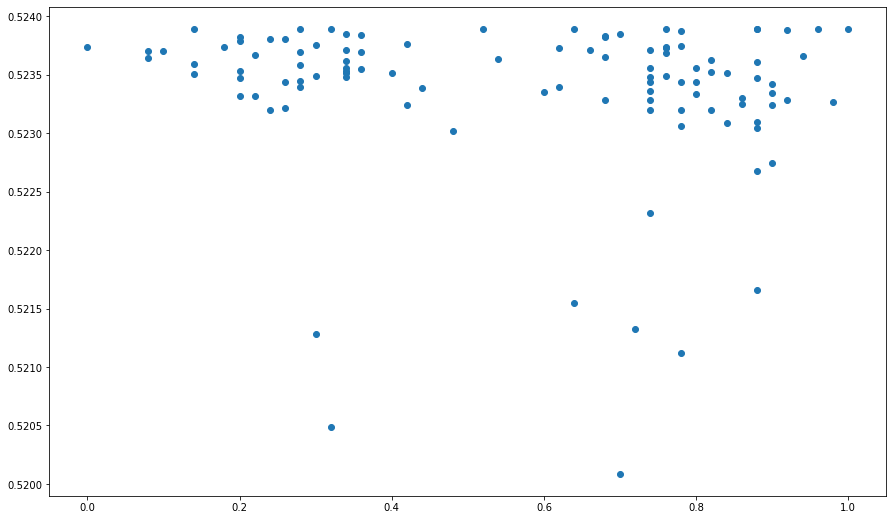

In [269]:
test = np.array([0.3730,0.3870,0.3460,0.4060,0.4050,0.4600,0.4544,0.4522,0.4100,0.4152,0.4611,0.3855,0.3735,0.3878,0.3464,0.4069,0.4051,0.4604,0.4546,0.4523,0.4101,0.4154,0.4618,0.3856])

plt.scatter(y_test_tensors.detach().numpy(), outputs.detach().numpy())
plt.show()